In [212]:
#Import all necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
import datetime

In [216]:
flights = pd.read_csv("data/flights_cleaned.csv")

In [175]:
cities = flights.drop_duplicates('origin_city_name')[['origin_city_name','fl_date']]
cities.rename(columns={'origin_city_name':'city, ST'})

,"city, ST",fl_date
0,"Detroit, MI",2019-05-22
1,"Boston, MA",2019-07-04
2,"New York, NY",2019-06-27
3,"Denver, CO",2018-04-05
4,"Baltimore, MD",2019-02-08
...,...,...
58984,"Bullhead City, AZ",2018-02-03
68378,"Watertown, SD",2019-12-18
74592,"Branson, MO",2018-11-05
74757,"Hyannis, MA",2018-08-15


In [148]:
flights['origin_city_name'].value_counts().sort_values()

Gustavus, AK                 3
Rota, TT                     3
Bullhead City, AZ            3
Hyannis, MA                  4
Ogden, UT                    4
                         ...  
Denver, CO               10401
Dallas/Fort Worth, TX    11114
New York, NY             11330
Atlanta, GA              14867
Chicago, IL              18059
Name: origin_city_name, Length: 366, dtype: int64

In [176]:
cities_samp = cities.sample(80)
cities_samp

,origin_city_name,fl_date
271,"Fayetteville, AR",2019-09-01
6168,"San Angelo, TX",2019-10-21
4657,"Springfield, IL",2019-12-14
1031,"Monroe, LA",2018-10-23
238,"Grand Junction, CO",2019-07-25
...,...,...
171,"Burbank, CA",2019-09-30
2733,"Fairbanks, AK",2018-04-04
46,"Charlotte, NC",2019-04-26
7740,"Laredo, TX",2018-04-12


In [177]:
weather_data = cities_samp.values.tolist()

In [178]:
weather_data[0][0]

'Fayetteville, AR'

In [179]:
url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history"

weather = []

for i in weather_data:
    
    start_date = datetime.datetime.strptime(i[1], "%Y-%M-%d")
    end_date = start_date + datetime.timedelta(days=1)

    
    querystring = {"contentType":"json",
               "startDateTime":f"{str(start_date.date())}T00:00:00",
               "aggregateHours":"24","location":f"{i[0]}",
               "endDateTime":f"{str(end_date.date())}T00:00:00",
               "unitGroup":"us",
               "key":"UQKQQXNCJ7GE3BLU8R9YITBHS"}
    
    response = requests.request("GET", url, headers=headers, params=querystring)
    weather.append(response.json())

In [189]:
JSON(weather)

<IPython.core.display.JSON object>

In [205]:
wh_data = []
for i in range(80):
    try:
        wh_data.append(weather[i]['locations'][weather_data[i][0]]['values'][0]['conditions'])
    except:
        wh_data.append(None)

In [206]:
cities_samp['weather'] = wh_data

In [245]:
data = pd.merge(cities_samp, flights[['dep_delay','arr_delay']], left_index=True, right_index=True)

In [246]:
data.isnull().sum()

origin_city_name    0
fl_date             0
weather             1
dep_delay           0
arr_delay           0
dtype: int64

In [247]:
data.dropna(inplace=True)

In [257]:
data.sort_values(['dep_delay','arr_delay'],ascending=False)

,origin_city_name,fl_date,weather,dep_delay,arr_delay
14034,"Moab, UT",2019-04-28,Clear,859.0,858.0
4238,"Lewiston, ID",2018-02-23,Partially cloudy,210.0,199.0
238,"Grand Junction, CO",2019-07-25,Clear,161.0,161.0
46,"Charlotte, NC",2019-04-26,Clear,150.0,135.0
3197,"Manhattan/Ft. Riley, KS",2019-05-09,Clear,66.0,47.0
...,...,...,...,...,...
4212,"Lake Charles, LA",2019-11-24,Clear,-14.0,-31.0
2598,"St. Petersburg, FL",2019-07-22,Clear,-15.0,-24.0
12696,"Hattiesburg/Laurel, MS",2019-09-25,Clear,-17.0,-31.0
4123,"Lynchburg, VA",2019-01-05,Partially cloudy,-19.0,-21.0


In [258]:
data[data['weather'] == "Clear"]['weather']

6168     Clear
1031     Clear
238      Clear
613      Clear
31259    Clear
1791     Clear
18708    Clear
3988     Clear
74       Clear
4002     Clear
99       Clear
4212     Clear
2598     Clear
12696    Clear
14034    Clear
936      Clear
434      Clear
3197     Clear
61       Clear
177      Clear
57       Clear
4989     Clear
183      Clear
35       Clear
17765    Clear
345      Clear
273      Clear
1203     Clear
326      Clear
389      Clear
926      Clear
1925     Clear
85       Clear
19       Clear
2370     Clear
203      Clear
171      Clear
46       Clear
7740     Clear
Name: weather, dtype: object

In [259]:
data.groupby('weather').count()

,origin_city_name,fl_date,dep_delay,arr_delay
weather,,,,
,1,1,1,1
Clear,39,39,39,39
Overcast,5,5,5,5
Partially cloudy,12,12,12,12
Rain,5,5,5,5
"Rain, Overcast",5,5,5,5
"Rain, Partially cloudy",9,9,9,9
Snow,1,1,1,1
"Snow, Overcast",1,1,1,1


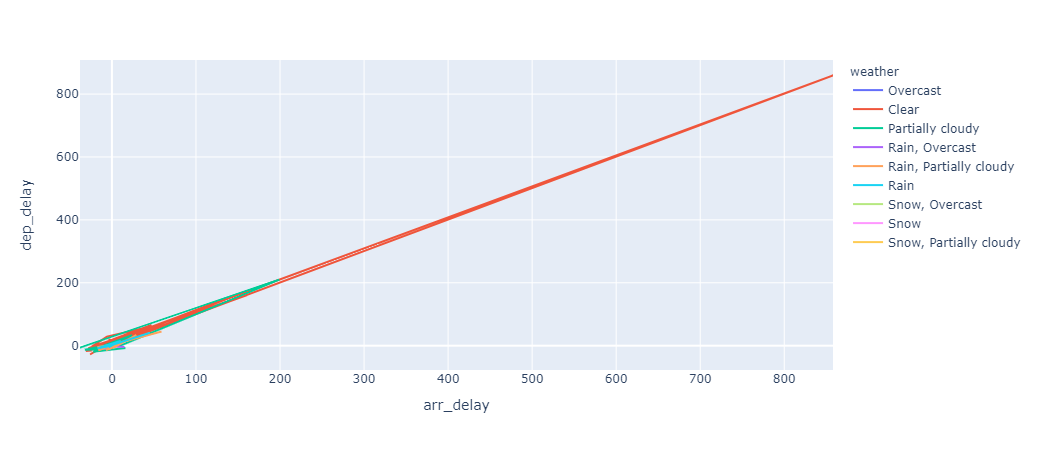

In [261]:
df = px.data.gapminder().query("continent == 'Oceania'")
fig = px.line(data, x='arr_delay', y='dep_delay', color='weather')
fig.show()